In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../..')
from database.connection import get_db_manager

In [2]:
BACKGROUND_COLOR = '#313332'
FONT_FAMILY = 'DejaVu Sans'

node_cmap = mcolors.LinearSegmentedColormap.from_list("", [
    'deepskyblue', 'cyan', 'lawngreen', 'yellow', 
    'gold', 'lightpink', 'tomato'
])

os.makedirs('figures', exist_ok=True)

In [3]:
db = get_db_manager()

query = """
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_domestic p
WHERE p.season = '2425'
ORDER BY p.league, p.team, p.player_name
"""

df_raw = pd.read_sql(query, db.engine)
db.close()

print(f"Extracted: {df_raw.shape[0]} records")

2025-09-20 15:00:02,920 - database.connection - INFO - Connecting to database: localhost:5432/footballdecoded_dev
2025-09-20 15:00:03,513 - database.connection - INFO - Database connection successful


Extracted: 2772 records


In [4]:
def extract_metrics(df, col_name):
    result = pd.DataFrame(index=df.index)
    
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                try:
                    values.append(float(raw_value))
                except (ValueError, TypeError):
                    values.append(np.nan)
            else:
                values.append(np.nan)
        
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

fbref_nums = extract_metrics(df_raw, 'fbref_metrics')
understat_nums = extract_metrics(df_raw, 'understat_metrics')

exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_per90)]
fbref_per90 = (fbref_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_per90)]
understat_per90 = (understat_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]

all_metrics = pd.concat([fbref_nums, understat_nums, fbref_per90, understat_per90], axis=1)

df = pd.concat([
    df_raw[['unique_player_id', 'player_name', 'team', 'league', 'position']],
    all_metrics
], axis=1)

df = df[df['minutes_played'] >= 800].copy()
print(f"Filtered 800+ minutes: {df.shape[0]} players")
print(f"Total metrics: {all_metrics.shape[1]} (including per90 versions)")

Filtered 800+ minutes: 1627 players
Total metrics: 356 (including per90 versions)


In [5]:
def get_top_players(plot_df, metric_col, top_n=10):
    return plot_df.nlargest(top_n, metric_col)

def format_player_name(name):
    parts = name.split()
    if len(parts) >= 2:
        return f"{parts[0][0]}. {parts[-1]}"
    return name

def create_scatter_plot(x_col, y_col, title, x_label, y_label, filename,
                       position_filter=None, add_diagonal=False, metric_type=""):

    plot_df = df.copy()
    if position_filter:
        plot_df = plot_df[plot_df['position'].str.contains(position_filter, na=False)]

    plot_df = plot_df.dropna(subset=[x_col, y_col])

    if plot_df.empty:
        print(f"No data for {title}")
        return

    plt.figure(figsize=(8, 6), facecolor=BACKGROUND_COLOR)
    ax = plt.gca()
    ax.set_facecolor(BACKGROUND_COLOR)

    top_players = get_top_players(plot_df, y_col)

    scatter = ax.scatter(plot_df[x_col], plot_df[y_col],
                        alpha=0.7, s=40,
                        c=plot_df[y_col], cmap=node_cmap,
                        edgecolors='white', linewidth=0.5)

    if add_diagonal:
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])
        ]
        ax.plot(lims, lims, 'white', alpha=0.8, zorder=0, linewidth=1)

    try:
        from adjustText import adjust_text
        texts = []
        for _, row in top_players.iterrows():
            formatted_name = format_player_name(row['player_name'])
            text = ax.text(row[x_col], row[y_col], formatted_name,
                          fontsize=8, color='yellow', alpha=0.9,
                          fontweight='bold', fontfamily=FONT_FAMILY,
                          bbox=dict(boxstyle='round,pad=0.2', facecolor=BACKGROUND_COLOR,
                                   edgecolor='yellow', alpha=0.8),
                          ha='center', va='center')
            texts.append(text)
        
        adjust_text(texts, 
                   force_points=0.5, force_text=0.8,
                   expand_points=(1.5, 1.5), expand_text=(1.2, 1.2),
                   arrowprops=dict(arrowstyle='->', color='yellow', alpha=0.7, lw=1))
        
    except ImportError:
        for i, (_, row) in enumerate(top_players.iterrows()):
            formatted_name = format_player_name(row['player_name'])
            
            angle = (i * 360 / len(top_players)) % 360
            radius = 15
            if angle < 90 or angle > 270:
                offset_x, offset_y = radius, radius * np.sin(np.radians(angle))
            else:
                offset_x, offset_y = -radius, radius * np.sin(np.radians(angle))
            
            ax.annotate(formatted_name,
                       (row[x_col], row[y_col]),
                       xytext=(offset_x, offset_y), textcoords='offset points',
                       fontsize=8, color='yellow', alpha=0.9,
                       fontweight='bold', fontfamily=FONT_FAMILY,
                       bbox=dict(boxstyle='round,pad=0.2', facecolor=BACKGROUND_COLOR,
                                edgecolor='yellow', alpha=0.8),
                       ha='center', va='center',
                       arrowprops=dict(arrowstyle='->', color='yellow', alpha=0.7))

    ax.set_xlabel(x_label, color='white', fontfamily=FONT_FAMILY, fontsize=12)
    ax.set_ylabel(y_label, color='white', fontfamily=FONT_FAMILY, fontsize=12)
    ax.set_title(title + f" {metric_type}", color='white', fontfamily=FONT_FAMILY,
                fontsize=14, fontweight='bold')

    ax.grid(True, color='grey', alpha=0.4, linewidth=0.5)
    ax.tick_params(colors='white', labelsize=10)

    for spine in ax.spines.values():
        spine.set_color('white')

    plt.figtext(0.025, -0.025, "Created by Jaime Oriol",
               fontweight='bold', fontsize=10, color="white", fontfamily=FONT_FAMILY)

    try:
        logo_path = "../logo/Logo-blanco.png"
        if os.path.exists(logo_path):
            logo = Image.open(logo_path)
            logo_ax = plt.gcf().add_axes([0.685, -0.075, 0.32, 0.15])
            logo_ax.imshow(logo)
            logo_ax.axis('off')
    except:
        plt.figtext(0.6, 0.02, "Football Decoded",
                   fontweight='bold', fontsize=14, color="white", fontfamily=FONT_FAMILY)

    plt.tight_layout()
    plt.savefig(f'figures/{filename}', dpi=300, facecolor=BACKGROUND_COLOR,
                bbox_inches='tight', edgecolor='none')
    plt.show()

    print(f"Saved: figures/{filename}")

def create_dual_scatter_plots(x_col, y_col, title_base, x_label_base, y_label_base,
                             filename_base, position_filter=None, add_diagonal=False):

    create_scatter_plot(x_col, y_col, title_base, x_label_base, y_label_base,
                       f"{filename_base}_global.png", position_filter, add_diagonal, "(Global)")

    x_per90 = f"{x_col}_per90" if f"{x_col}_per90" in df.columns else None
    y_per90 = f"{y_col}_per90" if f"{y_col}_per90" in df.columns else None

    if x_per90 and y_per90:
        create_scatter_plot(x_per90, y_per90, title_base,
                           f"{x_label_base} (per 90)", f"{y_label_base} (per 90)",
                           f"{filename_base}_per90.png", position_filter, add_diagonal, "(Per 90)")
    else:
        print(f"Per 90 metrics not available for {title_base}")

2025-09-20 15:02:07,848 - adjustText - WARNING - Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


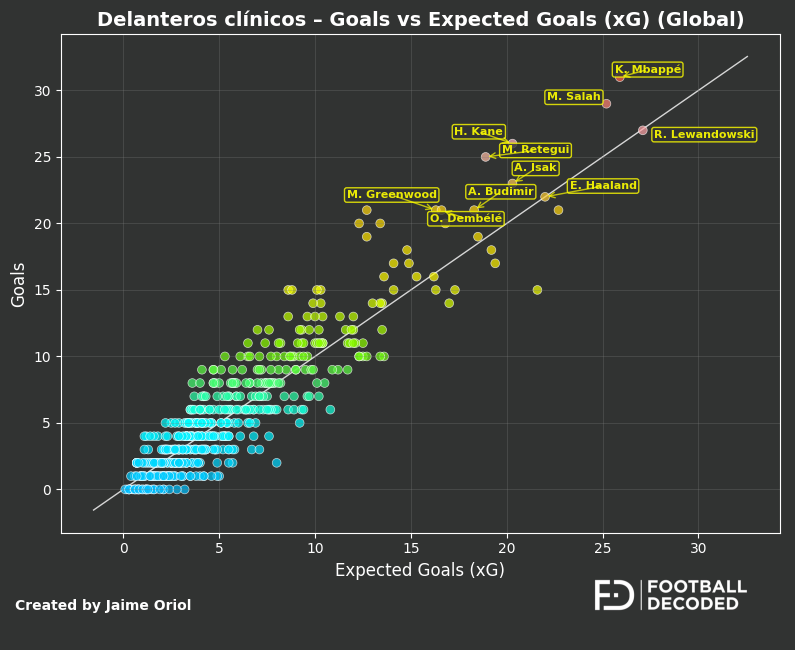

Saved: figures/delanteros_goals_vs_xg_global.png


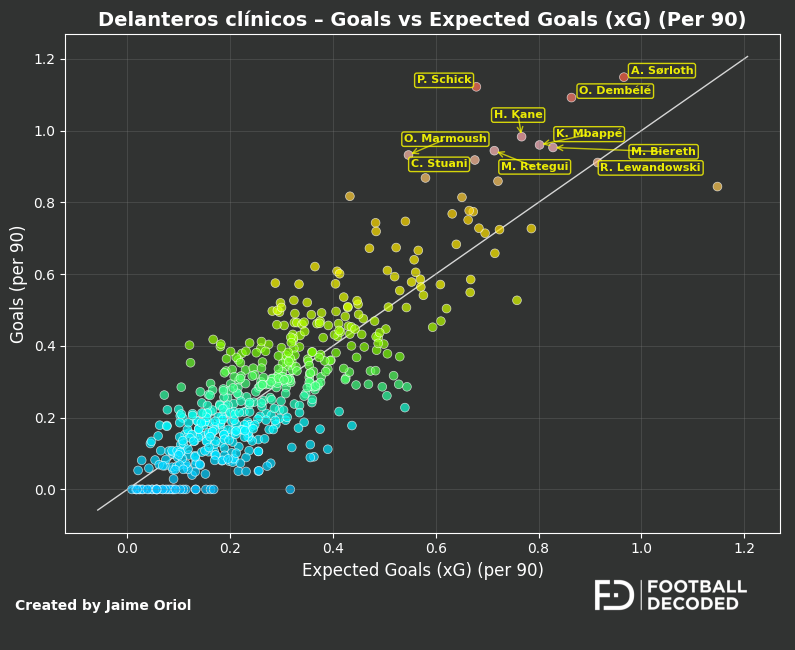

Saved: figures/delanteros_goals_vs_xg_per90.png


In [6]:
create_dual_scatter_plots(
    x_col='expected_goals',
    y_col='goals',
    title_base='Delanteros clínicos – Goals vs Expected Goals (xG)',
    x_label_base='Expected Goals (xG)',
    y_label_base='Goals',
    filename_base='delanteros_goals_vs_xg',
    position_filter='FW',
    add_diagonal=True
)

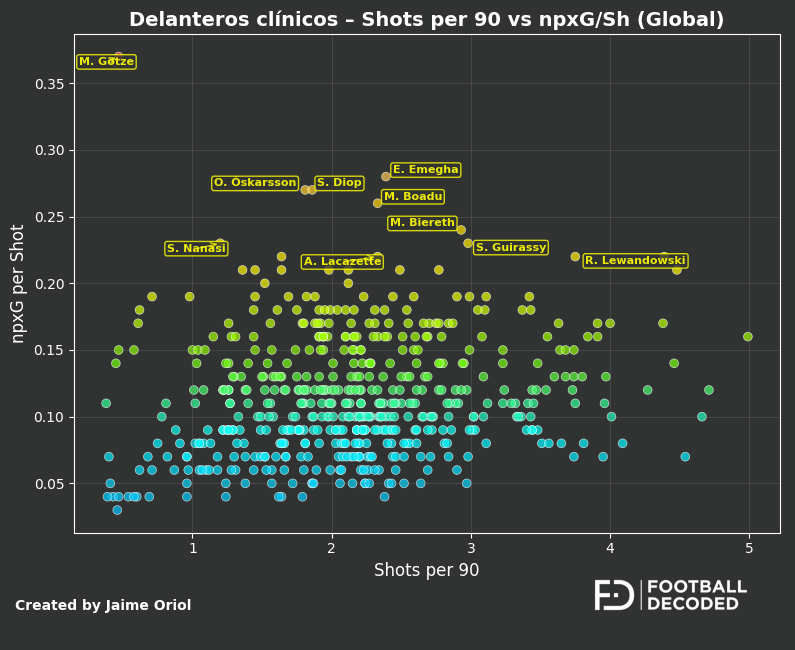

Saved: figures/delanteros_shots_vs_npxg_sh_global.png
Per 90 metrics not available for Delanteros clínicos – Shots per 90 vs npxG/Sh


In [7]:
create_dual_scatter_plots(
    x_col='shots_per_90',
    y_col='npxG/Sh',
    title_base='Delanteros clínicos – Shots per 90 vs npxG/Sh',
    x_label_base='Shots per 90',
    y_label_base='npxG per Shot',
    filename_base='delanteros_shots_vs_npxg_sh',
    position_filter='FW'
)

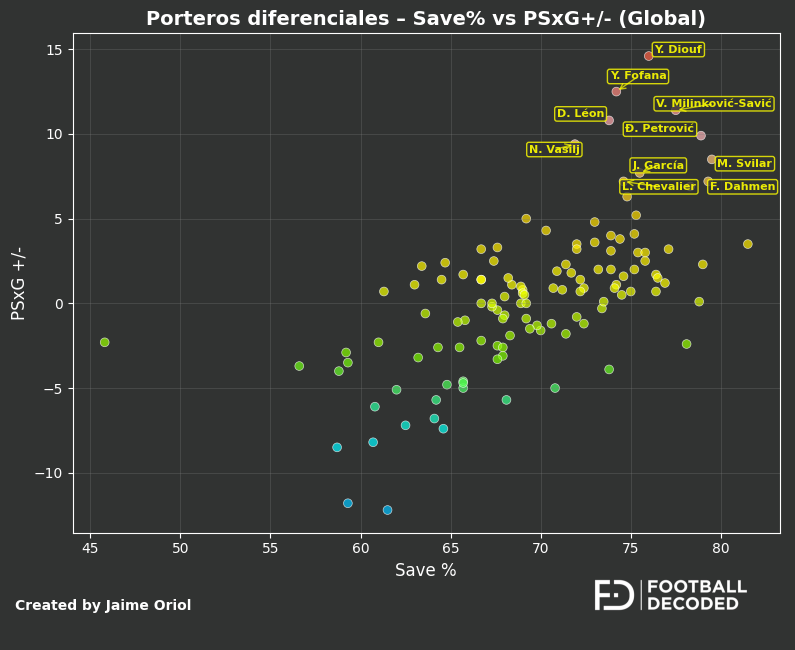

Saved: figures/porteros_save_vs_psxg_global.png
Per 90 metrics not available for Porteros diferenciales – Save% vs PSxG+/-


In [8]:
create_dual_scatter_plots(
    x_col='Save%',
    y_col='PSxG+/-',
    title_base='Porteros diferenciales – Save% vs PSxG+/-',
    x_label_base='Save %',
    y_label_base='PSxG +/-',
    filename_base='porteros_save_vs_psxg',
    position_filter='GK'
)

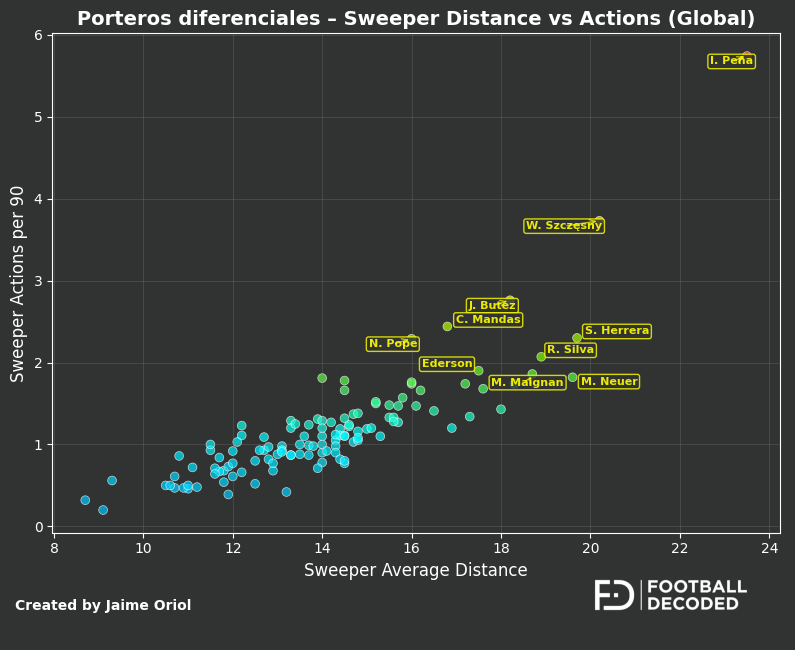

Saved: figures/porteros_sweeper_dist_vs_actions_global.png


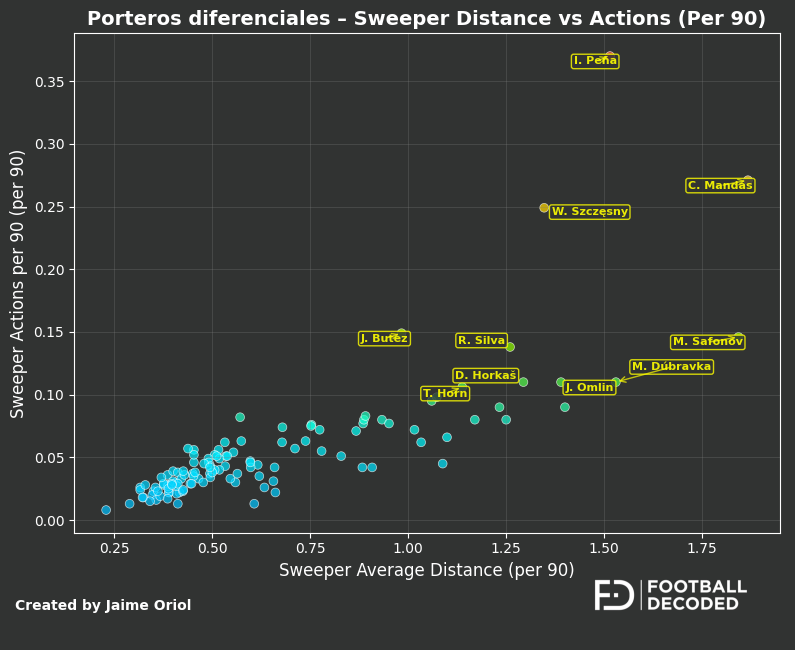

Saved: figures/porteros_sweeper_dist_vs_actions_per90.png


In [9]:
create_dual_scatter_plots(
    x_col='Sweeper_AvgDist',
    y_col='Sweeper_#OPA/90',
    title_base='Porteros diferenciales – Sweeper Distance vs Actions',
    x_label_base='Sweeper Average Distance',
    y_label_base='Sweeper Actions per 90',
    filename_base='porteros_sweeper_dist_vs_actions',
    position_filter='GK'
)

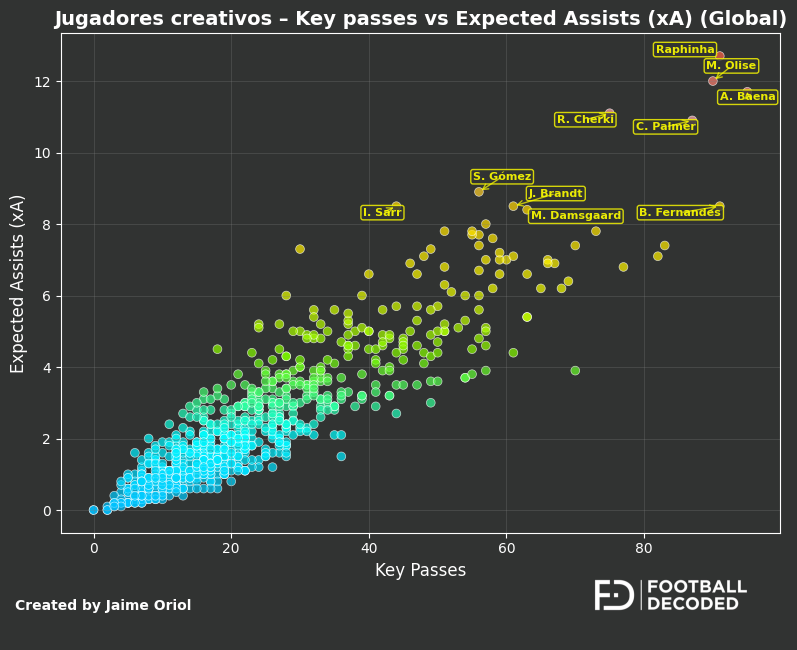

Saved: figures/creativos_key_passes_vs_xa_global.png


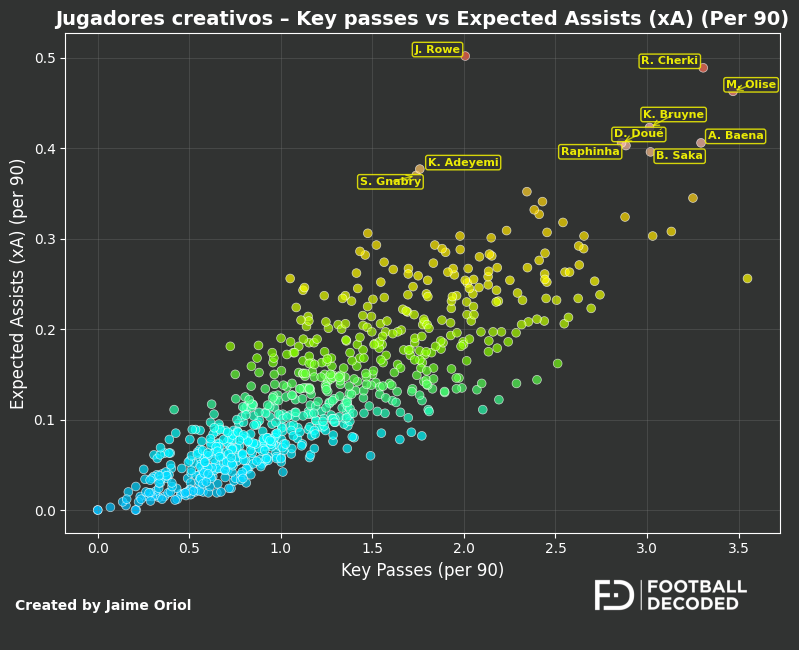

Saved: figures/creativos_key_passes_vs_xa_per90.png


In [10]:
create_dual_scatter_plots(
    x_col='key_passes',
    y_col='expected_assists',
    title_base='Jugadores creativos – Key passes vs Expected Assists (xA)',
    x_label_base='Key Passes',
    y_label_base='Expected Assists (xA)',
    filename_base='creativos_key_passes_vs_xa',
    position_filter='MF'
)

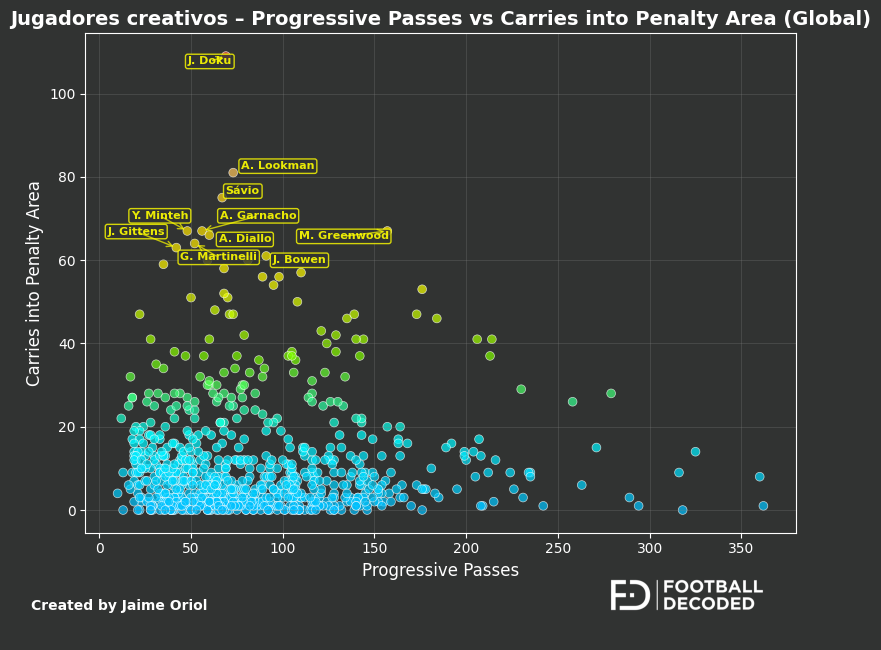

Saved: figures/creativos_progressive_vs_carries_cpa_global.png


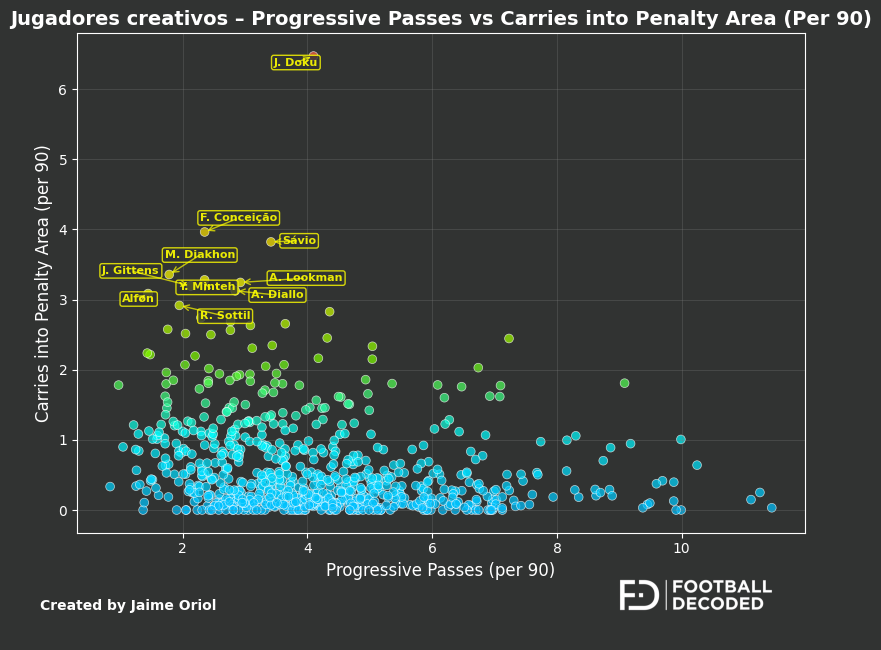

Saved: figures/creativos_progressive_vs_carries_cpa_per90.png


In [11]:
create_dual_scatter_plots(
    x_col='progressive_passes',
    y_col='Carries_CPA',
    title_base='Jugadores creativos – Progressive Passes vs Carries into Penalty Area',
    x_label_base='Progressive Passes',
    y_label_base='Carries into Penalty Area',
    filename_base='creativos_progressive_vs_carries_cpa',
    position_filter='MF'
)